# Estimer une probabilité de dépassement de seuil par les méthodes FORM-SORM - Application au cas de la poutre en flexion


## Déviation  verticale d'une poutre encastrée

On considère le modèle de [poutre encastrée](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/0-Deroulement/Poutre-encastree.md). 

## Quantité d'intérêt

It is considered that failure occurs when the beam deviation is greater than 0.21 m:
$$
Y \geq 0.21 \textrm{ (cm)}
$$
With a Monte-Carlo sample size equal to 1 200 000, we get:
$$
P(Y\geq 0.21) = 0.034686.
$$
The 95% confidence interval is 
$$
P([0.034358,0.035013]\ni P_f)=0.95.
$$

## References

* http://openturns.github.io/openturns/master/auto_reliability_sensitivity/reliability/plot_FORM_explained.html
* http://openturns.github.io/openturns/master/auto_reliability_sensitivity/reliability/plot_multi_form.html
* https://en.wikipedia.org/wiki/Curvature#Graph_of_a_function
* "Structural reliability", Maurice Lemaire, Wiley (2009). 
* M. Hohenbichler, S. Goldwitzer, W. Kruse and R. Rackwitz. New light on first- and second-order reliability methods. Structural Safety, 4: 267–284, 1987.
* M. Hohenbichler. Numerical Evaluation of the Error Term in Breitung’s Formula. Technical Report 69, Technical University of Munich, 1984.
* K. Breitung. Asymptotic approximations for multinormal integrals. Journal of the Engineering Mechanical Division, ASCE, 110(3): 357–366, March 1984.

# Model definition

In [1]:
import openturns as ot
import numpy as np
import otbenchmark as otb

In [ ]:
distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # En mètres
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # En m⁴
distributionI.setDescription(["I"])

X = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])

In [ ]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (m)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un mécanisme d'historique.

In [4]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [ ]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (m)"])

## Utilisation de la méthode FORM

Nous créons un `ThresholdEvent` associé à l'évènement : $E = \{Y > 30\}$. La probabilité recherché est $p_f = \mathbb{P}(E)$. 

In [ ]:
event = ot.ThresholdEvent(Y, ot.Greater(), 0.21)

Pour résoudre le problème d'optimisation, on utilise la méthode d'Abdo-Rackwitz, qui est spécialisée pour la méthode FORM.

In [7]:
solver = ot.AbdoRackwitz()

L'algorithme d'optimisation nécessite un point de départ dans l'espace physique. Pour cela, on utilise le centre du domaine physique c'est à dire la moyenne du vecteur aléatoire en entrée du modèle. 

In [8]:
physicalStartingPoint = X.getMean()
physicalStartingPoint

class=Point name=Unnamed dimension=4 values=[3.38065e+07,30000,255,397.5]

On peut alors utiliser la classe `FORM` et exécuter l'algorithme avec la méthode `run`. 

In [9]:
algo = ot.FORM(solver, event, physicalStartingPoint)
algo.run()
result = algo.getResult()

La méthode `getEventProbability` retourne la probabilité recherchée. 

In [10]:
pf_FORM = result.getEventProbability()
print("Probability of failure (FORM) Pf = ", pf_FORM)

Probability of failure (FORM) Pf =  0.006582138715175771


On observe que la méthode FORM produit la solution $\hat{p}_f = 0.006582$, ce qui est relativement proche de la solution de référence: l'ordre de grandeur est correct, mais la solution n'est pas très précise. 

In [11]:
g.getEvaluationCallsNumber()

13

On observe que seulement 13 évaluations ont été nécessaires. Comparé à la méthode de Monte-Carlo, c'est une performance remarquable: lorsqu'elle fonctionne correctement, la méthode FORM est très économique. 

La méthode `getStandardSpaceDesignPoint` retourne le point de conception dans l'espace standard.

In [12]:
designPointStandardSpace = result.getStandardSpaceDesignPoint()
designPointStandardSpace

class=Point name=Standard Space Design Point dimension=4 values=[-0.604806,2.32791,0.251194,-0.54668]

On observe que la variable F (la seconde composante) possède une valeur standard $U_F$ relativement éloignée du centre du domaine, relativement aux autres.

La méthode `getIsStandardPointOriginInFailureSpace` retourne `True` si l'origine est défaillante dans l'espace standard. Ici, l'origine n'est pas défaillante dans l'espace standard. 

In [13]:
result.getIsStandardPointOriginInFailureSpace()

False

## Utilisation de la méthode SORM

Pour utiliser la méthode SORM, on utilise la classe du même nom :

In [14]:
algo = ot.SORM(solver, event, physicalStartingPoint)
algo.run()
result = algo.getResult()

In [15]:
pf_Breitung = result.getEventProbabilityBreitung()
pf_Hohenbichler = result.getEventProbabilityHohenbichler()
pf_Tvedt = result.getEventProbabilityTvedt()

print("Probability of failure (SORM Breintung) Pf = ", pf_Breitung)
print("Probability of failure (SORM Hohenbichler) Pf = ", pf_Hohenbichler)
print("Probability of failure (SORM Tvedt) Pf = ", pf_Tvedt)

Probability of failure (SORM Breintung) Pf =  0.005416445713327257
Probability of failure (SORM Hohenbichler) Pf =  0.005306863742455129
Probability of failure (SORM Tvedt) Pf =  0.005273810867877709


## Dessiner la fonction d'état limite

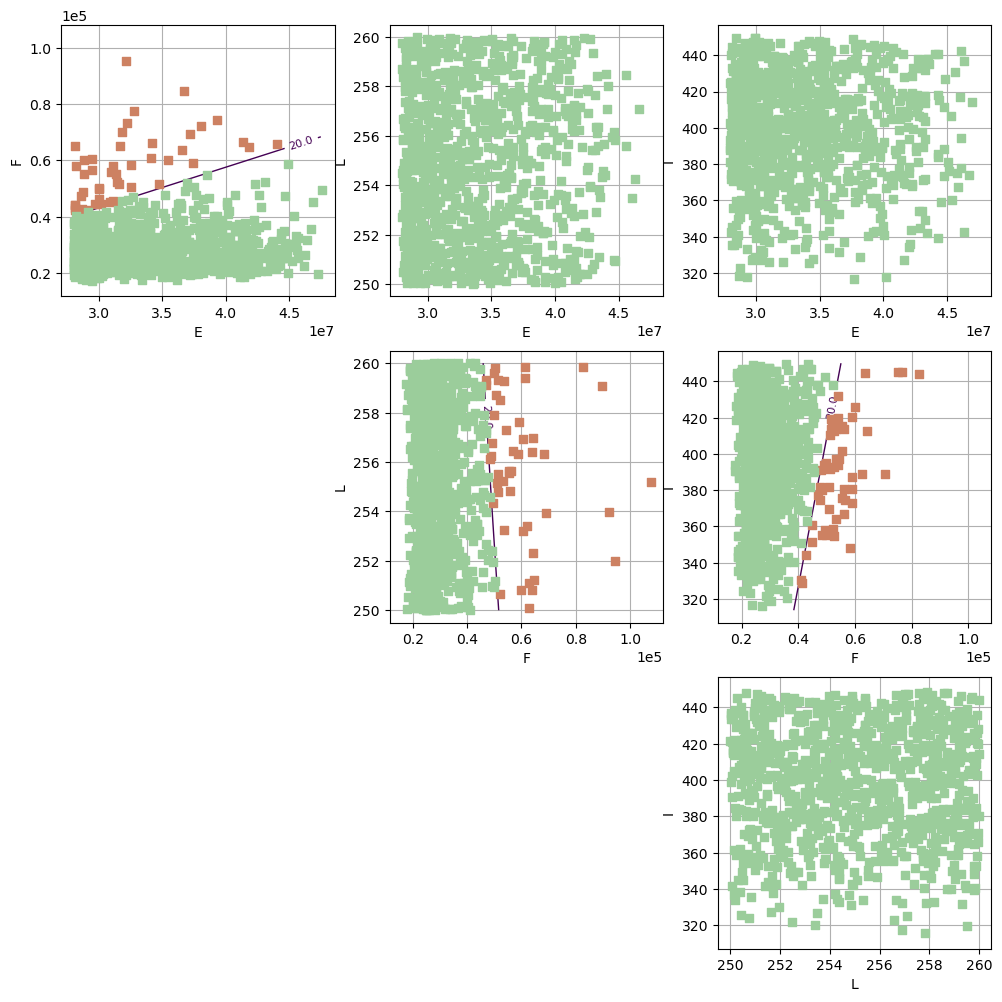

In [16]:
event = ot.ThresholdEvent(
    Y, ot.Greater(), 20.0
)  # Lower threshold to make it fail more often.
alpha = 1.0 - 0.001
bounds, marginalProb = X.computeMinimumVolumeIntervalWithMarginalProbability(alpha)
drawEvent = otb.DrawEvent(event)
_ = drawEvent.draw(bounds, nX=100)

Plot the event in the standard space.

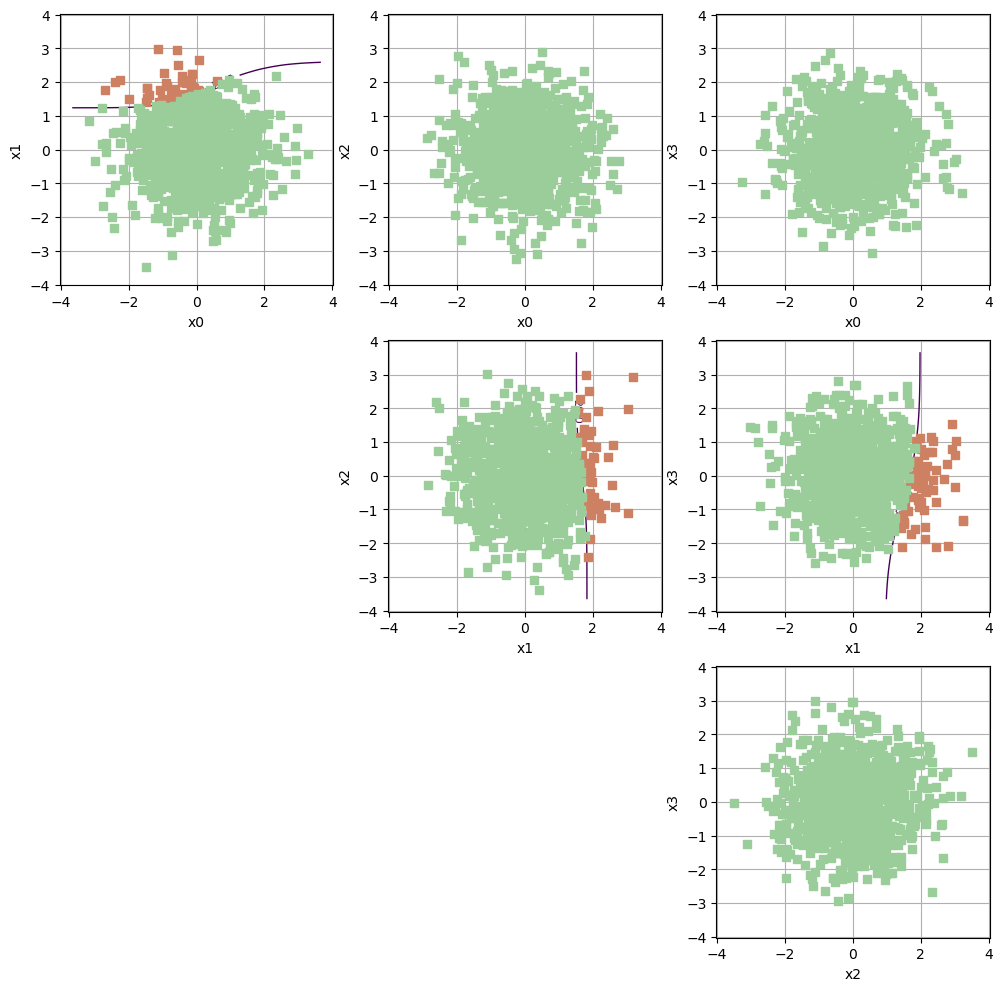

In [17]:
alpha = 1.0 - 0.001
dimension = X.getDimension()
standardDistribution = ot.Normal(dimension)
bounds, marginalProb = (
    standardDistribution.computeMinimumVolumeIntervalWithMarginalProbability(alpha)
)
standardEvent = ot.StandardEvent(event)
drawEvent = otb.DrawEvent(standardEvent)
_ = drawEvent.draw(bounds)

## Exercice 1 : faire varier le seuil

On souhaite observer comment la probabilité évolue lorsque le seuil change. 

*Questions*

* Changer la valeur du seuil et estimer la probabilité $p_f = \mathbb{P}(E)$ de l'évènement $E = \{Y > s\}$ pour $s=10, 15, ..., 100$ par pas de 5. 
* Pour chaque valeur du seuil, afficher la probabilité de défaillance et le nombre d'appels à la fonction $g$. Qu'observez-vous ?
* Combien d'appels au code seraient nécessaire pour estimer la probabilité $p_f$ pour le seuil $s=100$ par une méthode de Monte-Carlo simple avec un coefficient de variation égal à 0.1?
* Dessiner la probabilité estimée en fonction du seuil. Utiliser une échelle logarithmique pour l'axe des ordonnées. Quelle est l'allure générale de la courbe ?

## Exercice 2 : vérifier le calcul FORM

$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

Soit $g_s$ la fonction d'état limite :

$$
g_s(\vect{x}) = s - g(\vect{x})
$$

pour tout $\vect{x}\in\mathbb{R}^p$. 

Soit $h$ la fonction issue de la composition de la transformation isoprobabiliste $T$ et de la fonction $g_s$ :

$$
h(\vect{u}) = g_s\left[T^{-1}(\vect{u})\right]
$$

pour tout $\vect{u}\in\mathbb{R}^p$. 

On a vu en cours que, si la fonction $h$ est linéaire dans l'espace standard, alors :

$$
p_f = 
\begin{cases}
\Phi(-\beta) & \textrm{ si l'origine de l'espace standard est fiable}, \\
\Phi(\beta) & \textrm{sinon}
\end{cases}
$$

où $\Phi$ est la fonction de répartition de la loi Gaussienne standard. 

Voir également sur ce sujet (Lemaire, 2009), p.170, Proposition 1.

*Questions*

* Utiliser le seuil $s=30$ et la méthode FORM pour obtenir le résultat. 
* Utiliser la méthode `getIsStandardPointOriginInFailureSpace` pour déterminer si l'origine de l'espace standard est défaillante ou non. 
* Calculer l'estimation FORM de la probabilité.

## Exercice 3 : vérifier l'équation SORM

L'approximation asymptotique de Breitung (voir (Breitung, 1984) et (Lemaire, 2009), p.190, eq.7.20) est :

$$
\hat{p}_f = \frac{\Phi(-\beta)}{\prod_{i=1}^p \sqrt{1 + \beta \kappa_i}}
$$

où $\kappa_i$ est la ième courbure.

L'approximation précédente ne peut être appliquée que si $1 + \beta \kappa_i > 0$ pour $i=1,\ldots, p$. Elle n'est valide que pour des valeurs de $\beta$ grandes c'est à dire si $\beta\rightarrow +\infty$.

Une amélioration de l'approximation de Breitung est celle de Hohenbichler (voir (Hohenbichler, 1984) et (Lemaire, 2009), p.194):

$$
\hat{p}_f = \frac{\Phi(-\beta)}{\prod_{i=1}^p \sqrt{1 + \frac{\phi(\beta)}{\Phi(-\beta)} \kappa_i}}.
$$


L'objectif de cet exercice est d'utiliser les approximations SORM de Breitung et Hohenbichler pour vérifier le calcul OpenTURNS. 

*Questions*

* Utiliser la classe `SORM` puis la méthode `getResult` pour obtenir le résultat. 
* Utiliser la méthode `getHasoferReliabilityIndex` pour déterminer l'indice de fiabilité $\beta$.
* Utiliser la méthode `getSortedCurvatures` pour obtenir les courbures $\kappa_1, \ldots, \kappa_4$. 
* Evaluer l'approximation de Breitung et comparer avec la sortie de la méthode `getEventProbabilityBreitung`.
* Evaluer l'approximation de Hohenbichler et comparer avec la sortie de la méthode `getEventProbabilityHohenBichler`.